# Koch SQUID MCG + BSPM ECG (Paired Dataset)

## BSPM (ECG-like) preprocessing

- Loaded all 33 BSPM channels

- Removed channel 33 (respiration)

- Kept 32 ECG channels

- Sampling rate: 1000 Hz

- Detected R-peaks from a stable BSPM lead

- Extracted 2-second paired ECG windows:
- → Shape: (32 × 2000)

- Applied per-beat median/MAD normalization


## MCG (SQUID magnetocardiography) preprocessing
- Loaded all 100 SQUID channels from multiple modules
(A1, V1, X1, Z1, Z2, Z3)

- Verified sampling rate: 1000 Hz

- Signals in femto-Tesla (fT) (unit of magnetic field)

- Aligned all channels to a uniform 100,000-sample timeline

- Extracted 2-second MCG windows around each R-peak
- → Shape: (100 × 2000)

- Applied median/MAD normalization


## Created ECG–MCG paired beats
For each detected R-peak →
- BSPM ECG beat ↔ MCG beat mapped to the same heartbeat

- Final paired dataset (koch_pairs.npz):

- ECG beats: (127, 32, 2000)

- MCG beats: (127, 100, 2000)

- Sampling rate: 1000 Hz

- Descriptive metadata included


In [2]:
import os
from glob import glob

import numpy as np
from scipy.signal import butter, filtfilt, find_peaks


# ==========================
# 1. PATHS – EDIT THIS PART
# ==========================

KOCH_ROOT = r"C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch"
#KOCH_ROOT = "C:\\Users\\user\\Documents\\GitHub\\Game_of_SQUIDE\\SQUIDE\\dATASET\\dataset_2\\koch" 

MOESM6_DIR = os.path.join(KOCH_ROOT, "MOESM6")  # BSPM (ECG-like)
MOESM7_DIR = os.path.join(KOCH_ROOT, "MOESM7")  # part 1 of MCG (A1, V1, X1)
MOESM8_DIR = os.path.join(KOCH_ROOT, "MOESM8")  # part 2 of MCG (Z1, Z2, Z3)

OUT_FILE = "koch_pairs.npz"
FS = 1000  # sampling frequency: 1 ms interval


# ==========================
# 2. LOADING FUNCTIONS
# ==========================

def load_bspm_ecg(moesm6_dir):
    """
    Load BSPM (ECG-like) signals from MOESM6/BSPM_data/BSPM_CH_E*.txt

    Returns:
        ecg_bspm: (C_ecg, T)
        file_list: list of txt file paths
    """
    bspm_folder = os.path.join(moesm6_dir, "BSPM_data")
    txt_files = sorted(glob(os.path.join(bspm_folder, "BSPM_CH_E*.txt")))
    if not txt_files:
        raise RuntimeError(f"No BSPM_CH_E*.txt files found in {bspm_folder}")

    channels = []
    for f in txt_files:
        data = np.loadtxt(f, dtype=np.float32)
        channels.append(data)

    # Align lengths
    min_len = min(len(ch) for ch in channels)
    channels = [ch[:min_len] for ch in channels]
    ecg_bspm = np.stack(channels, axis=0)  # (C, T)

    print(f"[BSPM] Loaded {ecg_bspm.shape[0]} channels, length {ecg_bspm.shape[1]} samples")

    # Scale as per paper: multiply by -1.0 * 10^(-6) to get mV
    ecg_bspm = -1.0e-6 * ecg_bspm

    # Channel 33 is respiration → E33 → index 32 (0-based)
    if ecg_bspm.shape[0] >= 33:
        idx = np.arange(ecg_bspm.shape[0])
        idx = idx[idx != 32]
        ecg_bspm = ecg_bspm[idx, :]
        print(f"[BSPM] Dropped channel 33 (respiration). New shape: {ecg_bspm.shape}")

    return ecg_bspm, txt_files


def load_mcg_group(folder):
    """
    Load all *.txt files from a given MCG_CH_* folder, e.g. MCG_CH_A1, MCG_CH_Z1.

    Returns:
        arr: (C_group, T)
        files: list of txt paths
    """
    txt_files = sorted(glob(os.path.join(folder, "MCG_CH_*.txt")))
    if not txt_files:
        raise RuntimeError(f"No MCG_CH_*.txt in {folder}")

    channels = []
    for f in txt_files:
        data = np.loadtxt(f, dtype=np.float32)
        channels.append(data)

    min_len = min(len(ch) for ch in channels)
    channels = [ch[:min_len] for ch in channels]
    arr = np.stack(channels, axis=0)
    print(f"[MCG group] {folder} -> {arr.shape[0]} channels, {arr.shape[1]} samples")
    return arr, txt_files


def load_full_mcg(moesm7_dir, moesm8_dir):
    """
    Load all MCG channels from MOESM7 (MCG_CH_A1, V1, X1) and
    MOESM8 (MCG_CH_Z1, Z2, Z3) and concatenate along channel axis.

    Returns:
        mcg_full: (C_mcg_total, T)
        file_list: list of paths
    """

    mcg_groups_7 = ["MCG_CH_A1", "MCG_CH_V1", "MCG_CH_X1"]
    mcg_groups_8 = ["MCG_CH_Z1", "MCG_CH_Z2", "MCG_CH_Z3"]

    all_arrays = []
    all_files = []

    # Load A1, V1, X1
    for grp in mcg_groups_7:
        folder = os.path.join(moesm7_dir, grp)
        if os.path.isdir(folder):
            arr, files = load_mcg_group(folder)
            all_arrays.append(arr)
            all_files.extend(files)
        else:
            print(f"[WARN] Missing folder: {folder}")

    # Load Z1, Z2, Z3
    for grp in mcg_groups_8:
        folder = os.path.join(moesm8_dir, grp)
        if os.path.isdir(folder):
            arr, files = load_mcg_group(folder)
            all_arrays.append(arr)
            all_files.extend(files)
        else:
            print(f"[WARN] Missing folder: {folder}")

    if not all_arrays:
        raise RuntimeError("No MCG groups found in MOESM7 or MOESM8")

    # Align lengths across all groups
    min_len = min(a.shape[1] for a in all_arrays)
    all_arrays = [a[:, :min_len] for a in all_arrays]

    mcg_full = np.concatenate(all_arrays, axis=0)  # (C_total, T)
    print(f"[MCG] Total concatenated shape: {mcg_full.shape}")
    return mcg_full, all_files


# ==========================
# 3. R-PEAK DETECTION
# ==========================

def bandpass_filter(signal, fs=1000, low=5.0, high=15.0, order=2):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, signal)


def detect_r_peaks(signal, fs=1000, distance_ms=300, height_factor=0.4):
    """
    Very basic R-peak detector for clean signals.
    """
    filtered = bandpass_filter(signal, fs=fs, low=5.0, high=15.0, order=2)
    distance = int(distance_ms * fs / 1000.0)
    height = height_factor * np.max(filtered)
    peaks, _ = find_peaks(filtered, distance=distance, height=height)
    return peaks


def normalize_beat(x):
    """
    Channel-wise median/MAD normalization for a single beat window.
    x: (C, T)
    """
    m = np.median(x, axis=1, keepdims=True)
    mad = np.median(np.abs(x - m), axis=1, keepdims=True) + 1e-6
    return (x - m) / mad


# ==========================
# 4. MAIN
# ==========================

def main():
    # Load ECG (BSPM)
    ecg_bspm, ecg_files = load_bspm_ecg(MOESM6_DIR)

    # Load MCG (all groups from MOESM7 + MOESM8)
    mcg, mcg_files = load_full_mcg(MOESM7_DIR, MOESM8_DIR)

    # Align time length between ECG and MCG
    T = min(ecg_bspm.shape[1], mcg.shape[1])
    ecg_bspm = ecg_bspm[:, :T]
    mcg = mcg[:, :T]
    print(f"[ALIGN] ECG shape: {ecg_bspm.shape}, MCG shape: {mcg.shape}")

    # Choose one ECG channel for R-peaks (channel 0 for now)
    r_lead = ecg_bspm[0, :]
    r_peaks = detect_r_peaks(r_lead, fs=FS, distance_ms=300, height_factor=0.4)
    print(f"[R-PEAKS] Detected {len(r_peaks)} peaks")

    # Extract 2-second windows around each R-peak
    pre = int(0.5 * FS)   # 500 ms before R
    post = int(1.5 * FS)  # 1500 ms after R
    win_len = pre + post  # 2000 samples

    ecg_beats = []
    mcg_beats = []

    for r in r_peaks:
        start = r - pre
        end = r + post
        if start < 0 or end > T:
            continue

        ecg_win = ecg_bspm[:, start:end]  # (C_ecg, win_len)
        mcg_win = mcg[:, start:end]       # (C_mcg, win_len)

        if ecg_win.shape[1] != win_len or mcg_win.shape[1] != win_len:
            continue

        ecg_norm = normalize_beat(ecg_win).astype(np.float32)
        mcg_norm = normalize_beat(mcg_win).astype(np.float32)

        ecg_beats.append(ecg_norm)
        mcg_beats.append(mcg_norm)

    ecg_beats = np.stack(ecg_beats, axis=0)  # (N, C_ecg, 2000)
    mcg_beats = np.stack(mcg_beats, axis=0)  # (N, C_mcg, 2000)

    print(f"[RESULT] ECG beats: {ecg_beats.shape}, MCG beats: {mcg_beats.shape}")

    # Save to NPZ
    np.savez_compressed(
        OUT_FILE,
        ecg_beats=ecg_beats,
        mcg_beats=mcg_beats,
        fs=np.array([FS], dtype=np.int32),
        ecg_channel_files=np.array(ecg_files, dtype=object),
        mcg_channel_files=np.array(mcg_files, dtype=object),
        description=np.array(["Koch ECG (BSPM) + SQUID MCG, paired 2s beats"], dtype=object),
    )
    print(f"[SAVE] Saved Koch ECG–MCG pairs to {OUT_FILE}")


if __name__ == "__main__":
    main()


[BSPM] Loaded 33 channels, length 100000 samples
[BSPM] Dropped channel 33 (respiration). New shape: (32, 100000)
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM7\MCG_CH_A1 -> 17 channels, 100000 samples
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM7\MCG_CH_V1 -> 19 channels, 100000 samples
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM7\MCG_CH_X1 -> 15 channels, 100000 samples
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM8\MCG_CH_Z1 -> 17 channels, 100000 samples
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM8\MCG_CH_Z2 -> 16 channels, 100000 samples
[MCG group] C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\dataset_2\koch\MOESM8\MCG_CH_Z3 -> 16 channels, 100000 samples
[MCG] Total concatenated shape: (100, 100000)
[ALIGN] ECG shape:

In [3]:
import numpy as np

data = np.load("koch_pairs.npz", allow_pickle=True)
ecg_beats = data["ecg_beats"]
mcg_beats = data["mcg_beats"]

print("ECG beats:", ecg_beats.shape)  # (127, 32, 2000)
print("MCG beats:", mcg_beats.shape)  # (127, 100, 2000)
print("fs:", data["fs"])
print("desc:", data["description"])


ECG beats: (127, 32, 2000)
MCG beats: (127, 100, 2000)
fs: [1000]
desc: ['Koch ECG (BSPM) + SQUID MCG, paired 2s beats']


In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset


class KochPairedBeatsDataset(Dataset):
    def __init__(self, npz_path="koch_pairs.npz", augment=False):
        """
        npz_path: path to the koch_pairs.npz file
        augment: if True, apply very light noise / jitter augmentations
        """
        data = np.load(npz_path, allow_pickle=True)
        self.ecg_beats = data["ecg_beats"]  # (N, C_ecg, T)
        self.mcg_beats = data["mcg_beats"]  # (N, C_mcg, T)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.ecg_beats.shape[0]

    def _augment(self, x):
        """
        x: numpy array (C, T)
        very light augmentations: small Gaussian noise and tiny time shift
        """
        # small noise
        x = x + 0.01 * np.random.randn(*x.shape).astype(np.float32)

        # tiny circular time shift up to ±20 samples
        max_shift = 20
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)

        return x

    def __getitem__(self, idx):
        ecg = self.ecg_beats[idx]  # (C_ecg, T)
        mcg = self.mcg_beats[idx]  # (C_mcg, T)

        if self.augment:
            ecg = self._augment(ecg)
            mcg = self._augment(mcg)

        # convert to torch tensors
        ecg = torch.from_numpy(ecg)  # float32, shape (C_ecg, T)
        mcg = torch.from_numpy(mcg)  # float32, shape (C_mcg, T)

        return ecg, mcg


In [2]:
#from koch_dataset import KochPairedBeatsDataset
from torch.utils.data import DataLoader

ds = KochPairedBeatsDataset("koch_pairs.npz", augment=False)
print("Num beats:", len(ds))

loader = DataLoader(ds, batch_size=8, shuffle=True)
ecg, mcg = next(iter(loader))
print("ECG batch shape:", ecg.shape)  # expect: torch.Size([8, 32, 2000])
print("MCG batch shape:", mcg.shape)  # expect: torch.Size([8, 100, 2000])


Num beats: 127
ECG batch shape: torch.Size([8, 32, 2000])
MCG batch shape: torch.Size([8, 100, 2000])


# PTB Diagnostic ECG (Large Dataset)

- Loaded 12-lead ECG at 1000 Hz

- Detected R-peaks (Lead II)

- Extracted fixed 2-second heartbeat windows
(0.5 s before R-peak, 1.5 s after)
- → Shape: (12 channels × 2000 samples)

- Applied per-beat normalization:

- median subtraction

- MAD (robust scale) normalization

- Saved clean beats as ptb_beats.npz

In [7]:
import os
from glob import glob
from collections import defaultdict

import numpy as np
import wfdb
from scipy.signal import butter, filtfilt, find_peaks


# ==========================
# 1. CONFIG – EDIT THIS PATH
# ==========================

PTB_ROOT ="C:\\Users\\RAZER\\Documents\\GitHub\\Game_of_SQUIDE\SQUIDE\dATASET\\ptb-diagnostic-ecg-database-1.0.0\\ptb-diagnostic-ecg-database-1.0.0"   # TODO: change to PTB folder

OUT_FILE = "ptb_beats.npz"

# Standard 12-lead names in PTB (lowercase in wfdb)
STANDARD_LEADS = ['i', 'ii', 'iii', 'avr', 'avl', 'avf',
                  'v1', 'v2', 'v3', 'v4', 'v5', 'v6']


# ==========================
# 2. HELPERS
# ==========================

def list_ptb_records(ptb_root):
    """
    Find all PTB records by searching for .hea files.
    Returns a list of record paths without extension, e.g.
    '...\\patient001\\s0010_re'
    """
    rec_paths = []
    for patient_dir in sorted(glob(os.path.join(ptb_root, 'patient*'))):
        for hea in sorted(glob(os.path.join(patient_dir, '*.hea'))):
            rec_paths.append(hea[:-4])  # drop '.hea'
    return rec_paths


def bandpass_filter(signal, fs=1000, low=5.0, high=15.0, order=2):
    """
    Simple bandpass filter for QRS detection.
    signal: 1D array
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)


def detect_r_peaks(ecg_lead, fs=1000, distance_ms=300, height_factor=0.4):
    """
    Very simple R-peak detector on a single lead.
    ecg_lead: 1D numpy array
    """
    filtered = bandpass_filter(ecg_lead, fs=fs, low=5.0, high=15.0, order=2)
    distance = int(distance_ms * fs / 1000.0)   # minimal distance between peaks
    height = height_factor * np.max(filtered)   # threshold
    peaks, _ = find_peaks(filtered, distance=distance, height=height)
    return peaks


# ==========================
# 3. MAIN: BUILD PTB BEATS
# ==========================

def main():
    rec_paths = list_ptb_records(PTB_ROOT)
    print(f"Found {len(rec_paths)} PTB records")

    all_beats = []
    all_record_names = []
    all_subject_ids = []
    all_labels = []  

    for rec_path in rec_paths:
        rec_name = os.path.basename(rec_path)
        patient_id = os.path.basename(os.path.dirname(rec_path))

        try:
            record = wfdb.rdrecord(rec_path)
        except Exception as e:
            print(f"[WARN] Failed to read {rec_path}: {e}")
            continue

        sig = record.p_signal       # shape (T, n_channels)
        fs = int(record.fs)         # should be 1000
        ch_names = [ch.lower() for ch in record.sig_name]

        # Map 12 standard leads to indices
        lead_indices = []
        for ln in STANDARD_LEADS:
            if ln in ch_names:
                lead_indices.append(ch_names.index(ln))
            else:
                print(f"[WARN] Lead {ln} not found in {rec_path}, skipping record.")
                lead_indices = []
                break

        if not lead_indices:
            continue

        # Extract matrix of shape (12, T)
        ecg_12 = sig[:, lead_indices].T
        T = ecg_12.shape[1]

        # Use lead II for R-peak detection
        if 'ii' not in ch_names:
            print(f"[WARN] No lead II in {rec_path}, skipping.")
            continue
        lead2_index = ch_names.index('ii')
        lead2 = sig[:, lead2_index]

        # Detect R-peaks
        r_peaks = detect_r_peaks(lead2, fs=fs, distance_ms=300, height_factor=0.4)

        if len(r_peaks) < 5:
            print(f"[WARN] Few R-peaks ({len(r_peaks)}) in {rec_path}, skipping.")
            continue

        # 2-second window: [-0.5s, +1.5s] around each R → 2000 samples
        pre = int(0.5 * fs)    # 500 samples
        post = int(1.5 * fs)   # 1500 samples
        win_len = pre + post   # 2000

        for r in r_peaks:
            start = r - pre
            end = r + post
            if start < 0 or end > T:
                continue

            beat = ecg_12[:, start:end]  # (12, 2000)
            if beat.shape[1] != win_len:
                continue

            # Per-beat normalization (median + MAD)
            m = np.median(beat, axis=1, keepdims=True)
            mad = np.median(np.abs(beat - m), axis=1, keepdims=True) + 1e-6
            beat_norm = (beat - m) / mad

            all_beats.append(beat_norm.astype(np.float32))
            all_record_names.append(rec_name)
            all_subject_ids.append(patient_id)
            all_labels.append(0)  # placeholder

    if not all_beats:
        print("No beats collected. Check PTB_ROOT and data structure.")
        return

    all_beats = np.stack(all_beats, axis=0)  # (N, 12, 2000)
    all_record_names = np.array(all_record_names)
    all_subject_ids = np.array(all_subject_ids)
    all_labels = np.array(all_labels)

    print("PTB beats shape:", all_beats.shape)

    np.savez_compressed(
        OUT_FILE,
        beats=all_beats,
        record_names=all_record_names,
        subject_ids=all_subject_ids,
        labels=all_labels,
        fs=np.array([1000], dtype=np.int32),
        description=np.array(["PTB 12-lead beats, 2s windows around R-peaks"], dtype=object),
    )
    print(f"Saved PTB beats to {OUT_FILE}")


if __name__ == "__main__":
    main()


Found 549 PTB records
[WARN] Few R-peaks (2) in C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0\patient030\s0153lre, skipping.
[WARN] Few R-peaks (1) in C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0\patient044\s0159lre, skipping.
[WARN] Few R-peaks (1) in C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0\patient078\s0259lre, skipping.
[WARN] Few R-peaks (1) in C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0\patient101\s0400lre, skipping.
[WARN] Few R-peaks (1) in C:\Users\RAZER\Documents\GitHub\Game_of_SQUIDE\SQUIDE\dATASET\ptb-diagnostic-ecg-database-1.0.0\ptb-diagnostic-ecg-database-1.0.0\patient139\s0223_re, skipping.
[WARN] Few R-peaks (1) in C:\Users\RAZER\Do

In [8]:
import numpy as np

ptb = np.load("ptb_beats.npz", allow_pickle=True)
print("beats:", ptb["beats"].shape)          # (N, 12, 2000)
print("fs:", ptb["fs"])
print("desc:", ptb["description"])
print("examples from records:", ptb["record_names"][:5])
print("subjects:", ptb["subject_ids"][:5])


beats: (70507, 12, 2000)
fs: [1000]
desc: ['PTB 12-lead beats, 2s windows around R-peaks']
examples from records: ['s0010_re' 's0010_re' 's0010_re' 's0010_re' 's0010_re']
subjects: ['patient001' 'patient001' 'patient001' 'patient001' 'patient001']


In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset


class PTBBeatsDataset(Dataset):
    def __init__(self, npz_path="ptb_beats.npz", augment=True):
        data = np.load(npz_path, allow_pickle=True)
        self.beats = data["beats"]        # (N, 12, 2000)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.beats.shape[0]

    def _augment(self, x):
        # x: (12, T)
        x = x + 0.01 * np.random.randn(*x.shape).astype(np.float32)  # noise
        max_shift = 20
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)
        return x

    def __getitem__(self, idx):
        beat = self.beats[idx]
        if self.augment:
            beat = self._augment(beat)
        return torch.from_numpy(beat)


In [4]:
from torch.utils.data import DataLoader

ds_ptb = PTBBeatsDataset("ptb_beats.npz", augment=True)
loader_ptb = DataLoader(ds_ptb, batch_size=32, shuffle=True)

batch = next(iter(loader_ptb))
print(batch.shape)  # torch.Size([32, 12, 2000])


torch.Size([32, 12, 2000])


In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset


class PTBBeatsDataset(Dataset):
    def __init__(self, npz_path="ptb_beats.npz", augment=True):
        data = np.load(npz_path, allow_pickle=True)
        self.beats = data["beats"]        # (N, 12, 2000)
        self.fs = int(data["fs"][0])
        self.augment = augment

    def __len__(self):
        return self.beats.shape[0]

    def _augment(self, x):
        """
        x: numpy array (12, T)
        Simple SimCLR-style augmentations:
        - small Gaussian noise
        - small circular time shift
        """
        x = x + 0.01 * np.random.randn(*x.shape).astype(np.float32)
        max_shift = 20
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            x = np.roll(x, shift, axis=1)
        return x

    def __getitem__(self, idx):
        x = self.beats[idx]  # (12, 2000)

        # For SimCLR we need TWO views of the same beat
        x1 = self._augment(x.copy())
        x2 = self._augment(x.copy())

        x1 = torch.from_numpy(x1)  # (12, 2000)
        x2 = torch.from_numpy(x2)

        return x1, x2


In [6]:
from torch.utils.data import DataLoader
#from ptb_dataset import PTBBeatsDataset

ds = PTBBeatsDataset("ptb_beats.npz", augment=True)
print("Num PTB beats:", len(ds))

loader = DataLoader(ds, batch_size=32, shuffle=True)
v1, v2 = next(iter(loader))
print(v1.shape, v2.shape)  # expect: [32, 12, 2000] [32, 12, 2000]


Num PTB beats: 70507
torch.Size([32, 12, 2000]) torch.Size([32, 12, 2000])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ECGEncoderCNN(nn.Module):
    """
    Simple 1D CNN encoder for ECG beats.
    Input: (B, C=12, T=2000)
    Output: (B, feat_dim)
    """
    def __init__(self, in_channels=12, feat_dim=256):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2   = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3   = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm1d(256)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, feat_dim)

    def forward(self, x):
        """
        x: (B, C, T)
        """
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 64, T/2)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 128, T/4)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 256, T/8)
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 256, T/16)
        x = self.global_pool(x)              # (B, 256, 1)
        x = x.squeeze(-1)                    # (B, 256)
        x = self.fc(x)                       # (B, feat_dim)
        return x


class ProjectionHead(nn.Module):
    """
    2-layer MLP projection head for SimCLR.
    Input: (B, feat_dim)
    Output: (B, proj_dim)
    """
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.fc2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # L2 normalize
        x = F.normalize(x, p=2, dim=-1)
        return x


In [8]:
import torch
import torch.nn.functional as F


def simclr_nt_xent_loss(z1, z2, temperature=0.1):
    """
    z1, z2: (B, D) normalized embeddings from two views of the same batch.
    Returns scalar loss.
    """
    assert z1.shape == z2.shape
    batch_size = z1.shape[0]

    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)  # (2B, 2B)

    # Mask to remove self-similarity
    self_mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim = sim / temperature

    # For each anchor i in 0..2B-1, define positives and negatives
    # Positives: (i, i+B) or (i, i-B) depending on which half
    labels = torch.arange(2 * batch_size, device=z.device)
    labels = (labels + batch_size) % (2 * batch_size)  # positive index for each anchor

    # For cross-entropy, we need logits (2B, 2B-1) and labels
    sim = sim.masked_fill(self_mask, -1e9)

    loss = F.cross_entropy(sim, labels)
    return loss


In [9]:
import torch
from torch.utils.data import DataLoader

#from ptb_dataset import PTBBeatsDataset
#from models import ECGEncoderCNN, ProjectionHead, simclr_nt_xent_loss


def train_ptb_simclr(
    npz_path="ptb_beats.npz",
    batch_size=64,
    lr=1e-3,
    epochs=50,
    device="cpu"
):
    # Dataset & DataLoader
    dataset = PTBBeatsDataset(npz_path=npz_path, augment=True)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # Model
    encoder = ECGEncoderCNN(in_channels=12, feat_dim=256)
    projector = ProjectionHead(in_dim=256, proj_dim=128)

    encoder.to(device)
    projector.to(device)

    optimizer = torch.optim.AdamW(
        list(encoder.parameters()) + list(projector.parameters()),
        lr=lr,
        weight_decay=1e-4,
    )

    encoder.train()
    projector.train()

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for step, (x1, x2) in enumerate(loader):
            x1 = x1.to(device)  # (B, 12, 2000)
            x2 = x2.to(device)

            optimizer.zero_grad()

            # Forward both views through encoder + projector
            h1 = encoder(x1)          # (B, 256)
            h2 = encoder(x2)          # (B, 256)
            z1 = projector(h1)        # (B, 128)
            z2 = projector(h2)        # (B, 128)

            loss = simclr_nt_xent_loss(z1, z2, temperature=0.1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / (step + 1)
        print(f"Epoch {epoch:03d}/{epochs} - SimCLR loss: {avg_loss:.4f}")

    # Save encoder weights to reuse for Koch cross-modal training
    torch.save(encoder.state_dict(), "ecg_encoder_ptb_simclr.pth")
    print("Saved pretrained ECG encoder to ecg_encoder_ptb_simclr.pth")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    train_ptb_simclr(
        npz_path="ptb_beats.npz",
        batch_size=64,
        lr=1e-3,
        epochs=10,
        device=device,
    )


Using device: cuda
Epoch 001/10 - SimCLR loss: 0.0935
Epoch 002/10 - SimCLR loss: 0.0330
Epoch 003/10 - SimCLR loss: 0.0227
Epoch 004/10 - SimCLR loss: 0.0251
Epoch 005/10 - SimCLR loss: 0.0206
Epoch 006/10 - SimCLR loss: 0.0231
Epoch 007/10 - SimCLR loss: 0.0189
Epoch 008/10 - SimCLR loss: 0.0175
Epoch 009/10 - SimCLR loss: 0.0164
Epoch 010/10 - SimCLR loss: 0.0159
Saved pretrained ECG encoder to ecg_encoder_ptb_simclr.pth


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv1DEncoder(nn.Module):
    """
    Generic 1D CNN encoder for time series.
    Used for ECG (C=12 or 32) and MCG (C=100).
    Input: (B, C, T)
    Output: (B, feat_dim)
    """
    def __init__(self, in_channels, feat_dim=256):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1   = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2   = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3   = nn.BatchNorm1d(256)

        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1)
        self.bn4   = nn.BatchNorm1d(256)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, feat_dim)

    def forward(self, x):
        # x: (B, C, T)
        x = F.relu(self.bn1(self.conv1(x)))  # (B, 64, T/2)
        x = F.relu(self.bn2(self.conv2(x)))  # (B, 128, T/4)
        x = F.relu(self.bn3(self.conv3(x)))  # (B, 256, T/8)
        x = F.relu(self.bn4(self.conv4(x)))  # (B, 256, T/16)
        x = self.global_pool(x)              # (B, 256, 1)
        x = x.squeeze(-1)                    # (B, 256)
        x = self.fc(x)                       # (B, feat_dim)
        return x


class ProjectionHead(nn.Module):
    """
    2-layer MLP projection head.
    Input: (B, feat_dim)
    Output: (B, proj_dim) normalized
    """
    def __init__(self, in_dim=256, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, in_dim)
        self.fc2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        return x


def cross_modal_info_nce(z_e, z_m, temperature=0.1):
    """
    Cross-modal InfoNCE loss between ECG (z_e) and MCG (z_m).
    z_e: (B, D) ECG embeddings (L2-normalized)
    z_m: (B, D) MCG embeddings (L2-normalized)

    We compute similarity matrix S = z_e @ z_m^T / T
    and use symmetric loss: ECG→MCG and MCG→ECG.
    """
    assert z_e.shape == z_m.shape
    B, D = z_e.shape

    # cosine similarity (since both are normalized, dot = cos)
    logits = z_e @ z_m.T / temperature  # (B, B)

    targets = torch.arange(B, device=z_e.device)

    # ECG→MCG
    loss_e2m = F.cross_entropy(logits, targets)

    # MCG→ECG (transpose)
    loss_m2e = F.cross_entropy(logits.T, targets)

    loss = 0.5 * (loss_e2m + loss_m2e)
    return loss


In [11]:
import torch
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import Conv1DEncoder, ProjectionHead, cross_modal_info_nce


def train_koch_crossmodal(
    npz_path="koch_pairs.npz",
    batch_size=8,
    lr=1e-3,
    epochs=100,
    device="cpu",
    pretrained_ecg_path=None
):
    # 1) Dataset & DataLoader
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=True)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # 2) Encoders: ECG (32 channels) and MCG (100 channels)
    ecg_encoder = Conv1DEncoder(in_channels=32, feat_dim=256)
    mcg_encoder = Conv1DEncoder(in_channels=100, feat_dim=256)

    # Optionally load pretrained ECG weights (from PTB SimCLR)
    if pretrained_ecg_path is not None:
        print(f"Loading PTB-pretrained ECG encoder from {pretrained_ecg_path}")
        load_ptb_weights_into_koch_encoder(ecg_encoder, pretrained_ecg_path,
                                           in_channels_ptb=12, in_channels_koch=32)

    # Projection heads
    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.to(device)
    mcg_encoder.to(device)
    ecg_proj.to(device)
    mcg_proj.to(device)

    # 3) Optimizer
    # can be  used smaller LR for pretrained ECG encoder 
    params = list(ecg_encoder.parameters()) + list(mcg_encoder.parameters()) \
             + list(ecg_proj.parameters()) + list(mcg_proj.parameters())

    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=1e-4)

    # 4) Training loop
    ecg_encoder.train()
    mcg_encoder.train()
    ecg_proj.train()
    mcg_proj.train()

    for epoch in range(1, epochs + 1):
        running_loss = 0.0

        for step, (ecg, mcg) in enumerate(loader):
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            optimizer.zero_grad()

            # Encode
            h_e = ecg_encoder(ecg)    # (B, 256)
            h_m = mcg_encoder(mcg)    # (B, 256)

            # Project
            z_e = ecg_proj(h_e)       # (B, 128)
            z_m = mcg_proj(h_m)       # (B, 128)

            # Cross-modal InfoNCE
            loss = cross_modal_info_nce(z_e, z_m, temperature=0.1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / (step + 1)
        print(f"Epoch {epoch:03d}/{epochs} - Cross-modal loss: {avg_loss:.4f}")

    # 5) Save trained models
    torch.save(ecg_encoder.state_dict(), "ecg_encoder_koch.pth")
    torch.save(mcg_encoder.state_dict(), "mcg_encoder_koch.pth")
    torch.save(ecg_proj.state_dict(), "ecg_proj_koch.pth")
    torch.save(mcg_proj.state_dict(), "mcg_proj_koch.pth")
    print("Saved ECG + MCG encoders and projection heads for Koch dataset")

import torch

def load_ptb_weights_into_koch_encoder(ecg_encoder, ckpt_path, in_channels_ptb=12, in_channels_koch=32):
    """
    Load PTB-pretrained weights (12 channels) into a Koch ECG encoder (32 channels).
    All layers except conv1 are loaded directly.
    conv1.weight is adapted by tiling the 12-channel kernels to 32 channels.
    """
    ckpt = torch.load(ckpt_path, map_location="cpu")
    enc_state = ecg_encoder.state_dict()

    new_state = {}

    for k, v in enc_state.items():
        if k == "conv1.weight":
            if "conv1.weight" in ckpt:
                w_ptb = ckpt["conv1.weight"]  # (64, 12, 7)
                # tile channels: repeat along in_channel dim until >=32, then cut
                repeat_factor = (in_channels_koch + in_channels_ptb - 1) // in_channels_ptb
                w_tiled = w_ptb.repeat(1, repeat_factor, 1)  # (64, 12*repeat, 7)
                w_tiled = w_tiled[:, :in_channels_koch, :]   # (64, 32, 7)
                new_state[k] = w_tiled
            else:
                new_state[k] = v  # fallback: keep random init
        elif k == "conv1.bias":
            if "conv1.bias" in ckpt:
                new_state[k] = ckpt["conv1.bias"]
            else:
                new_state[k] = v
        else:
            # for all other layers, load if shape matches, else keep default
            if k in ckpt and ckpt[k].shape == v.shape:
                new_state[k] = ckpt[k]
            else:
                new_state[k] = v

    ecg_encoder.load_state_dict(new_state)
    print("Loaded PTB weights into Koch ECG encoder (with conv1 channel adaptation).")




if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    pretrained_path = "ecg_encoder_ptb_simclr.pth"  

    train_koch_crossmodal(
    npz_path="koch_pairs.npz",
    batch_size=8,
    lr=1e-3,
    epochs=100,
    device=device,
    pretrained_ecg_path="ecg_encoder_ptb_simclr.pth",
    )



Using device: cuda
Loading PTB-pretrained ECG encoder from ecg_encoder_ptb_simclr.pth
Loaded PTB weights into Koch ECG encoder (with conv1 channel adaptation).
Epoch 001/100 - Cross-modal loss: 2.1175
Epoch 002/100 - Cross-modal loss: 2.0708
Epoch 003/100 - Cross-modal loss: 2.0683
Epoch 004/100 - Cross-modal loss: 2.0464
Epoch 005/100 - Cross-modal loss: 2.0800
Epoch 006/100 - Cross-modal loss: 2.0724
Epoch 007/100 - Cross-modal loss: 2.0618
Epoch 008/100 - Cross-modal loss: 1.9914
Epoch 009/100 - Cross-modal loss: 1.9405
Epoch 010/100 - Cross-modal loss: 1.8344
Epoch 011/100 - Cross-modal loss: 1.8303
Epoch 012/100 - Cross-modal loss: 1.6967
Epoch 013/100 - Cross-modal loss: 1.5759
Epoch 014/100 - Cross-modal loss: 1.7010
Epoch 015/100 - Cross-modal loss: 1.5317
Epoch 016/100 - Cross-modal loss: 1.4924
Epoch 017/100 - Cross-modal loss: 1.4064
Epoch 018/100 - Cross-modal loss: 1.4446
Epoch 019/100 - Cross-modal loss: 1.4066
Epoch 020/100 - Cross-modal loss: 1.2769
Epoch 021/100 - Cros

In [12]:
import torch
import numpy as np
from torch.utils.data import DataLoader

#from koch_dataset import KochPairedBeatsDataset
#from models import Conv1DEncoder, ProjectionHead


def eval_koch_retrieval(
    npz_path="koch_pairs.npz",
    ecg_encoder_path="ecg_encoder_koch.pth",
    mcg_encoder_path="mcg_encoder_koch.pth",
    ecg_proj_path="ecg_proj_koch.pth",
    mcg_proj_path="mcg_proj_koch.pth",
    batch_size=64,
    device="cpu",
):
    # 1) Dataset (no augmentation for evaluation)
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # 2) Rebuild models with correct channel counts
    ecg_encoder = Conv1DEncoder(in_channels=32, feat_dim=256)
    mcg_encoder = Conv1DEncoder(in_channels=100, feat_dim=256)
    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    # Load weights
    ecg_encoder.load_state_dict(torch.load(ecg_encoder_path, map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load(mcg_encoder_path, map_location="cpu"))
    ecg_proj.load_state_dict(torch.load(ecg_proj_path, map_location="cpu"))
    mcg_proj.load_state_dict(torch.load(mcg_proj_path, map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    # 3) Compute embeddings for all beats
    all_z_e = []
    all_z_m = []

    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)  # (B, 32, 2000)
            mcg = mcg.to(device)  # (B, 100, 2000)

            h_e = ecg_encoder(ecg)   # (B, 256)
            h_m = mcg_encoder(mcg)   # (B, 256)

            z_e = ecg_proj(h_e)      # (B, 128)
            z_m = mcg_proj(h_m)      # (B, 128)

            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0)  # (N, 128)
    z_m = torch.cat(all_z_m, dim=0)  # (N, 128)
    N = z_e.shape[0]
    print(f"Total beats: {N}")

    # 4) Cosine similarity matrix
    # embeddings are already L2-normalized by ProjectionHead, so dot = cosine
    sim = z_e @ z_m.T  # (N, N)

    # ECG -> MCG: for each ECG, find closest MCG
    preds_e2m = sim.argmax(dim=1)  # (N,)
    correct_e2m = (preds_e2m == torch.arange(N)).float().mean().item()

    # MCG -> ECG: for each MCG, find closest ECG
    preds_m2e = sim.argmax(dim=0)  # (N,)
    correct_m2e = (preds_m2e == torch.arange(N)).float().mean().item()

    print(f"ECG→MCG top-1 retrieval accuracy: {correct_e2m*100:.2f}%")
    print(f"MCG→ECG top-1 retrieval accuracy: {correct_m2e*100:.2f}%")

    # Optional: top-5 accuracy
    topk = 5
    # ECG -> MCG top-k
    topk_e2m = sim.topk(topk, dim=1).indices  # (N, K)
    correct_topk_e2m = (topk_e2m == torch.arange(N).unsqueeze(1)).any(dim=1).float().mean().item()

    # MCG -> ECG top-k
    topk_m2e = sim.topk(topk, dim=0).indices  # (K, N)
    correct_topk_m2e = (topk_m2e == torch.arange(N).unsqueeze(0)).any(dim=0).float().mean().item()

    print(f"ECG→MCG top-{topk} retrieval accuracy: {correct_topk_e2m*100:.2f}%")
    print(f"MCG→ECG top-{topk} retrieval accuracy: {correct_topk_m2e*100:.2f}%")


if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)
    eval_koch_retrieval(device=device)


Using device: cuda
Total beats: 127
ECG→MCG top-1 retrieval accuracy: 3.15%
MCG→ECG top-1 retrieval accuracy: 2.36%
ECG→MCG top-5 retrieval accuracy: 9.45%
MCG→ECG top-5 retrieval accuracy: 10.24%


Using device: cuda
Computed embeddings for N=127 beats


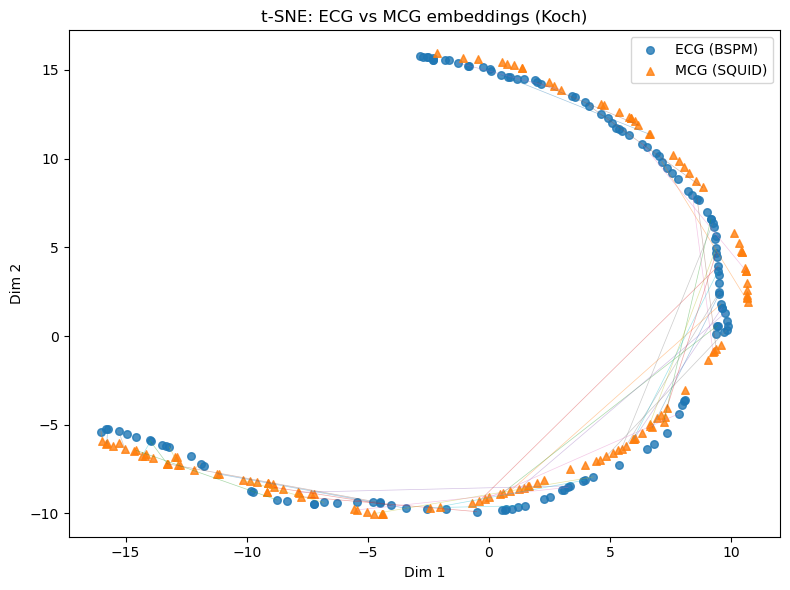

UMAP not installed; only t-SNE plot generated.


In [13]:
import numpy as np
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

#from koch_dataset import KochPairedBeatsDataset
#from models import Conv1DEncoder, ProjectionHead


def compute_embeddings(
    npz_path="koch_pairs.npz",
    ecg_encoder_path="ecg_encoder_koch.pth",
    mcg_encoder_path="mcg_encoder_koch.pth",
    ecg_proj_path="ecg_proj_koch.pth",
    mcg_proj_path="mcg_proj_koch.pth",
    batch_size=64,
    device="cpu",
):
    dataset = KochPairedBeatsDataset(npz_path=npz_path, augment=False)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Rebuild models
    ecg_encoder = Conv1DEncoder(in_channels=32, feat_dim=256)
    mcg_encoder = Conv1DEncoder(in_channels=100, feat_dim=256)
    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.load_state_dict(torch.load(ecg_encoder_path, map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load(mcg_encoder_path, map_location="cpu"))
    ecg_proj.load_state_dict(torch.load(ecg_proj_path, map_location="cpu"))
    mcg_proj.load_state_dict(torch.load(mcg_proj_path, map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    all_z_e = []
    all_z_m = []

    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)
            mcg = mcg.to(device)

            h_e = ecg_encoder(ecg)
            h_m = mcg_encoder(mcg)

            z_e = ecg_proj(h_e)   # (B, 128)
            z_m = mcg_proj(h_m)   # (B, 128)

            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0).numpy()  # (N, 128)
    z_m = torch.cat(all_z_m, dim=0).numpy()  # (N, 128)
    N = z_e.shape[0]
    print(f"Computed embeddings for N={N} beats")

    return z_e, z_m


def run_tsne(z_e, z_m, random_state=42):
    """
    z_e, z_m: (N, D) ECG and MCG embeddings
    Returns 2D embeddings for ECG and MCG separately.
    """
    N = z_e.shape[0]
    # Stack both modalities for joint t-SNE
    Z = np.vstack([z_e, z_m])  # (2N, D)

    tsne = TSNE(
        n_components=2,
        perplexity=min(30, 2 * N // 3),
        learning_rate="auto",
        init="random",
        random_state=random_state,
    )
    Z_2d = tsne.fit_transform(Z)  # (2N, 2)

    Z_e_2d = Z_2d[:N]
    Z_m_2d = Z_2d[N:]
    return Z_e_2d, Z_m_2d


def run_umap(z_e, z_m, random_state=42):
    """
    Optional UMAP projection.
    """
    N = z_e.shape[0]
    Z = np.vstack([z_e, z_m])  # (2N, D)

    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=min(15, N - 1),
        min_dist=0.1,
        metric="euclidean",
        random_state=random_state,
    )
    Z_2d = reducer.fit_transform(Z)

    Z_e_2d = Z_2d[:N]
    Z_m_2d = Z_2d[N:]
    return Z_e_2d, Z_m_2d


def plot_embeddings(Z_e_2d, Z_m_2d, title="t-SNE of ECG/MCG embeddings", connect_pairs=False, max_pairs=40):
    """
    Z_e_2d, Z_m_2d: (N, 2) arrays of 2D coords
    connect_pairs: if True, draw line between paired ECG–MCG embeddings
    max_pairs: limit number of lines to avoid clutter
    """
    N = Z_e_2d.shape[0]

    plt.figure(figsize=(8, 6))

    # ECG = circles
    plt.scatter(Z_e_2d[:, 0], Z_e_2d[:, 1],
                s=30, marker='o', alpha=0.8, label='ECG (BSPM)')

    # MCG = triangles
    plt.scatter(Z_m_2d[:, 0], Z_m_2d[:, 1],
                s=30, marker='^', alpha=0.8, label='MCG (SQUID)')

    if connect_pairs:
        num_lines = min(N, max_pairs)
        for i in range(num_lines):
            x_vals = [Z_e_2d[i, 0], Z_m_2d[i, 0]]
            y_vals = [Z_e_2d[i, 1], Z_m_2d[i, 1]]
            plt.plot(x_vals, y_vals, linewidth=0.5, alpha=0.4)

    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.tight_layout()
    plt.show()


def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using device:", device)

    # 1) Compute embeddings
    z_e, z_m = compute_embeddings(
        npz_path="koch_pairs.npz",
        ecg_encoder_path="ecg_encoder_koch.pth",
        mcg_encoder_path="mcg_encoder_koch.pth",
        ecg_proj_path="ecg_proj_koch.pth",
        mcg_proj_path="mcg_proj_koch.pth",
        batch_size=64,
        device=device,
    )

    # 2) t-SNE
    Z_e_tsne, Z_m_tsne = run_tsne(z_e, z_m, random_state=42)
    plot_embeddings(Z_e_tsne, Z_m_tsne,
                    title="t-SNE: ECG vs MCG embeddings (Koch)",
                    connect_pairs=True, max_pairs=40)

    # 3) Optional: UMAP
    if HAS_UMAP:
        Z_e_umap, Z_m_umap = run_umap(z_e, z_m, random_state=42)
        plot_embeddings(Z_e_umap, Z_m_umap,
                        title="UMAP: ECG vs MCG embeddings (Koch)",
                        connect_pairs=True, max_pairs=40)
    else:
        print("UMAP not installed; only t-SNE plot generated.")


if __name__ == "__main__":
    main()


Positive similarity mean ± std: 0.93514097 0.08001472
Negative similarity mean ± std: -0.006900617 0.68339276


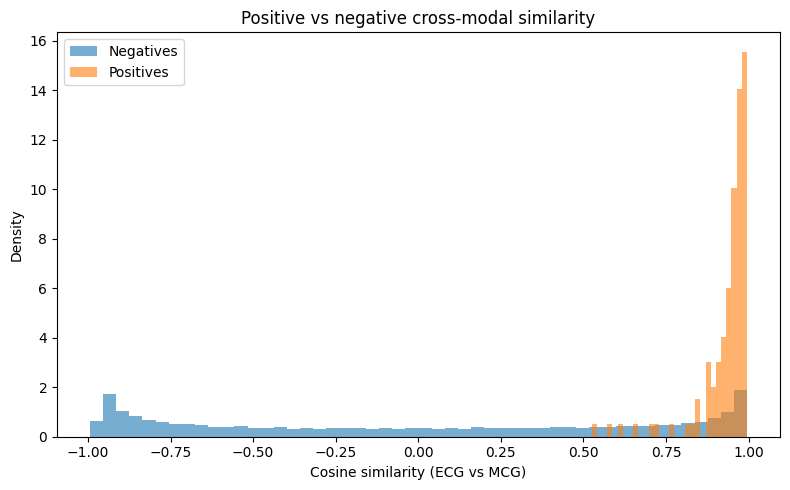

In [32]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

#from koch_dataset import KochPairedBeatsDataset
#from models import Conv1DEncoder, ProjectionHead


def compute_embeddings(device="cpu"):
    dataset = KochPairedBeatsDataset("koch_pairs.npz", augment=False)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

    ecg_encoder = Conv1DEncoder(in_channels=32, feat_dim=256)
    mcg_encoder = Conv1DEncoder(in_channels=100, feat_dim=256)
    ecg_proj = ProjectionHead(in_dim=256, proj_dim=128)
    mcg_proj = ProjectionHead(in_dim=256, proj_dim=128)

    ecg_encoder.load_state_dict(torch.load("ecg_encoder_koch.pth", map_location="cpu"))
    mcg_encoder.load_state_dict(torch.load("mcg_encoder_koch.pth", map_location="cpu"))
    ecg_proj.load_state_dict(torch.load("ecg_proj_koch.pth", map_location="cpu"))
    mcg_proj.load_state_dict(torch.load("mcg_proj_koch.pth", map_location="cpu"))

    ecg_encoder.to(device).eval()
    mcg_encoder.to(device).eval()
    ecg_proj.to(device).eval()
    mcg_proj.to(device).eval()

    all_z_e, all_z_m = [], []
    with torch.no_grad():
        for ecg, mcg in loader:
            ecg = ecg.to(device)
            mcg = mcg.to(device)
            h_e = ecg_encoder(ecg)
            h_m = mcg_encoder(mcg)
            z_e = ecg_proj(h_e)
            z_m = mcg_proj(h_m)
            all_z_e.append(z_e.cpu())
            all_z_m.append(z_m.cpu())

    z_e = torch.cat(all_z_e, dim=0)  # (N, D)
    z_m = torch.cat(all_z_m, dim=0)  # (N, D)
    return z_e, z_m


def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    z_e, z_m = compute_embeddings(device=device)
    N = z_e.shape[0]

    # Full similarity matrix
    sim = z_e @ z_m.T  # (N, N)

    # Positives = diagonal
    pos_sim = sim.diag().numpy()

    # Negatives = all off-diagonal entries (subsample to avoid N^2 blowup)
    mask = ~torch.eye(N, dtype=torch.bool)
    neg_sim_all = sim[mask].numpy()
    # Subsample for plotting
    if neg_sim_all.shape[0] > 20000:
        idx = np.random.choice(neg_sim_all.shape[0], 20000, replace=False)
        neg_sim = neg_sim_all[idx]
    else:
        neg_sim = neg_sim_all

    print("Positive similarity mean ± std:", pos_sim.mean(), pos_sim.std())
    print("Negative similarity mean ± std:", neg_sim.mean(), neg_sim.std())

    # Plot histograms
    plt.figure(figsize=(8, 5))
    plt.hist(neg_sim, bins=50, alpha=0.6, label="Negatives", density=True)
    plt.hist(pos_sim, bins=30, alpha=0.6, label="Positives", density=True)
    plt.xlabel("Cosine similarity (ECG vs MCG)")
    plt.ylabel("Density")
    plt.title("Positive vs negative cross-modal similarity")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
